# Alan Turing Institute

## What is my favourite Data Science or Machine Learning Method?

## James Golding

## Constrained Optimization
Optimization has applications everywhere. It is the brain behind the result. It makes the difference between a meaningful solution: one with a point to it (an objective you could say!), and random behaviour.
 
Optimization is at the core of many machine learning and data science techniques:
 - Neural Networks
 - Regression
 - Support Vector Machines


## Solving an Optimization Problem
A constrained optimization problem takes the form

$$\min_{\forall x \in \mathbb{R}^n} f(x)$$

$$s.t.$$

$$c(x) = 0$$
$$g(x) \geq 0$$

Looking at these in detail:
 - The constraint equation is well defined. It is a list of equalities that must be satisfied. If there are as many constraint equations as states, the problem is square and there is a unique solution. Easy.
 - The inequalities are well defined. They are conditions for validity of the solution. Either the solution satisfies them and is valid, or does not and is not valid. There is no in between.
 - The objective function presents us with a small problem. We cannot say anything about the behaviour of the objective function at the optimal solution without knowing something about the constraint equations.
 
This is where the auxiliary function comes in. It combines the objective function with the constraint equation and says that, at the solution, any direction you move in the feasible space (i.e. still satisfying the constraint equations) will result in an increase of the objective function. Formally, it is called the lagrangian and is posed in the following way:
 
$$\nabla\mathcal{L} = \nabla f(x) - \lambda_{c} \nabla c(x) - \lambda_{g} \nabla g(x) = 0$$
$$c(x) = 0$$
$$g(x) \geq 0$$

Each iteration is made in the direction of steepest descent (towards zero) of these functions, and a line search method is employed to choose an acceptable step size before the next gradient is calculated.

In [85]:
# packages required
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
import scipy.optimize as opt

% matplotlib inline
print("Done")

Done


In [86]:
# objective function
fmin = lambda x: (x[0] - 5) ** 2 + (x[1] - 7) ** 2

# equality and inequality constraints
cons = ({'type': 'ineq', 'fun': lambda x: 3 + 0.5 * x[0] - x[1]},
        {'type': 'ineq', 'fun': lambda x: -(5 - 1.5 * x[0] - x[1])},
        {'type': 'eq', 'fun': lambda x: 1 + 0.2 * x[0] ** 2 - x[1]})

# store the iterations
xL = []
def store(x):
    xL.append(list(x))
    
# call the solver
res = opt.minimize(fmin, 
                   np.zeros(2), 
                   constraints=cons, 
                   method="SLSQP", 
                   callback=store,
                   options={"disp": False})
xSol = np.array(xL);
print("Converged in " + str(res.nit) + " iterations")

Converged in 7 iterations


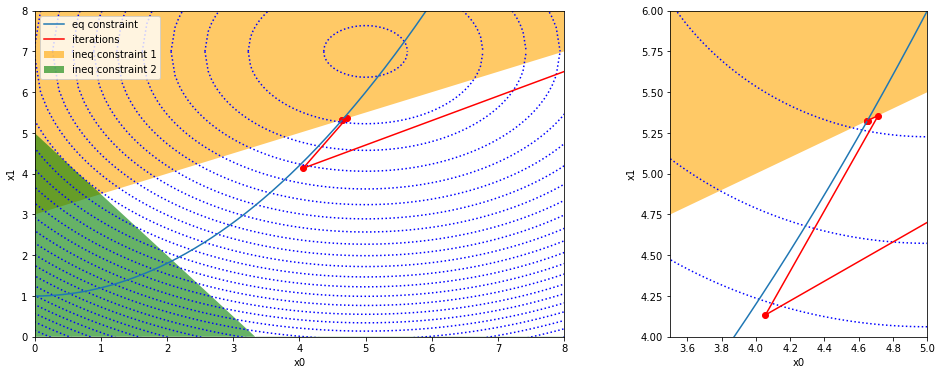

In [87]:
# plot result vs constraints
x0 = np.linspace(0, 8, 1000)
ic1 = 3 + 0.5 * x0
ic2 = 5 - 1.5 * x0
c1 = 1 + 0.2 * x0 ** 2

fig = plt.figure(figsize=[16, 6]);
ax1 = plt.subplot2grid((1, 10), (0, 0), colspan=6)
ax2 = plt.subplot2grid((1, 10), (0, 7), colspan=3)

def makeplot(ax):
    ax.fill_between(x0, ic1, 10, facecolor="orange", alpha=0.6, label="ineq constraint 1");
    ax.fill_between(x0, ic2, 0, facecolor="green", alpha=0.6, label="ineq constraint 2");
    for k in np.linspace(0.4, 80, 30):
        xcont = np.linspace(-np.sqrt(k) + 5 + 1e-10, np.sqrt(k) + 5 - 1e-10, 100)
        contsqrt = np.sqrt(k - (xcont - 5) ** 2)
        ax.plot(xcont, 7 + contsqrt, linestyle=":", c="blue")
        ax.plot(xcont, 7 - contsqrt, linestyle=":", c="blue")
    ax.plot(x0, c1, label="eq constraint");
    ax.plot(xSol[:,0], xSol[:,1], label="iterations", c="red");
    ax.scatter(xSol[:,0], xSol[:,1], c="red")
    ax.set_xlabel("x0");
    ax.set_ylabel("x1");

makeplot(ax1)
ax1.set_xlim([0, 8]);
ax1.set_ylim([0, 8]);
ax1.legend(loc=2);

makeplot(ax2)
ax2.set_xlim([3.5, 5]);
ax2.set_ylim([4, 6]);

## Optimization in Formula One
In its simplest form, we pose a lap simulation as an ODE of the form:
vdot = f(v, p)
Where v is the car velocity, p are track properties (such as track curvature), and f() includes the condition that the car is on the limit of performance.
$$f(x) = -gLong$$
$$c(x) = 0$$
<center>(constrain the solution to be stable, e.g. constant suspension travel)</center>
$$g(x) >= 0$$
<center>(set limits on the car stability and controllability)</center>

Factors to consider in this application:
 - The cost of a model call is high so the efficiency of the solver is especially important to us. Our solver is highly tuned and we avoid regular calls to the jacobian.
 - Homotopy variables can be used to speed up convergence, whilst maintaining model fidelity.
 - The model is highly non-linear. For this reason, it is beneficial to remain close to the equality constraints to avoid exploring regions of high rate of change (e.g. touching endstops).
 - Knowing the model is very beneficial. We can choose our model states wisely and modify the constraints to make the jacobian as constant as possible.
 - The lagrangian multipliers are the gradient of the objective function wrt the constraint equations. By adding constraints, we can extract linear sensitivities of the objective to important parameters, which can be used to explore the linear region around the solution.
 

## Optimization in Regression
Regression is an optimization of the minimum error between a modelled variable and the test dataset. This is a model identification problem, but the approach is very similar. The objective function is typically a mean squared error, since this is twice differentiable and improves convexity.
 
In this example we take data from a lap of the Australian GP and build tyre forces as a function of the available channels.

Equality constraints force the left and the right tyre parameters to be equal. This could be done by combining the data but for the sake of this exercise, it is a constrained optimization.

In [88]:
# parameters
LAPS = [1, 2, 3, 4]

FYNOISE = 800 #N

PSLIP0 = -0.2 #linear decay
PSLIPG = 1 #arctan gain 
PSLIPT = 1.5 #arctan op gain 
PCMBR  = 0.05 #gradient of friction coefficient wrt camber

# read data set
dataframeLaps = pd.read_csv("/Users/jamesgolding/Documents/MachineLearningDemo/10R01AUS_BUT_MCL_TYRE_CMB.csv")
print("Done")

Done


Tyre friction coefficient is a function of:
 - slip angle (the angle between the rolling direction and direction of travel)
 - camber angle (the rotation of the tyre about the axis of movement from vertical)

<img src="TyreDiagram.png" width="30%">

$$\mu_{y} = \gamma p_{Cmb}  + \alpha p_{SlipLin} + p_{SlipGain}^{2} \times \arctan(\alpha p_{SlipTan})$$
$$F_{y} = F_{z} \mu_{y}$$

The tyre force channels have noise added.

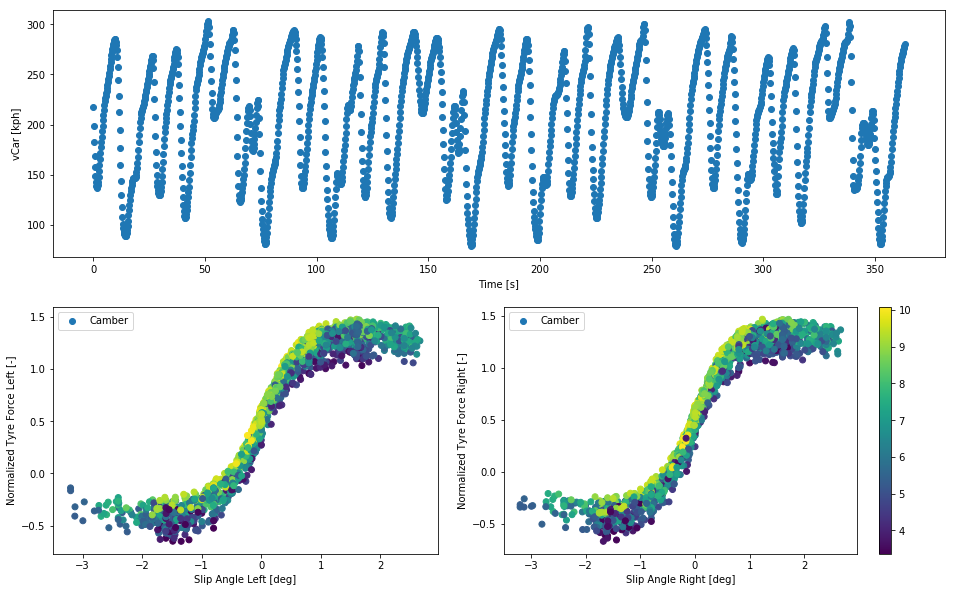

In [89]:
# write tyre model. square the gain on tan to make it positive definite
def tyrefun(x, aSlip, aCamber, Fz):
    muy =  x[3] * aCamber + x[0] * aSlip + x[1] ** 2 * np.arctan(x[2] * aSlip)
    Fy = muy * Fz
    return Fy

# lateral tyre load with noise
FyNoiseFL = FYNOISE * np.random.rand(np.size(dataframeLaps.Time))
FyNoiseFR = FYNOISE * np.random.rand(np.size(dataframeLaps.Time))

# create the state vector based on the real parameters
xParams = np.array([PSLIP0, PSLIPG, PSLIPT, PCMBR])

# add the modelled tyre force with noise
dataframeLaps["FyTyreFL"] = FyNoiseFL + tyrefun(xParams, dataframeLaps.aSlipFL, 
                                                dataframeLaps.aCamberFL, dataframeLaps.FzTyreFL)
dataframeLaps["FyTyreFR"] = FyNoiseFR + tyrefun(xParams, dataframeLaps.aSlipFR, 
                                                dataframeLaps.aCamberFR, dataframeLaps.FzTyreFR)

# separate out the lap we want
BMatchLap = [any(y == lap for lap in LAPS) for y in dataframeLaps.Lap]
dataframeLap = dataframeLaps[BMatchLap]

cmin = np.min(np.vstack([dataframeLap.aCamberFL, dataframeLap.aCamberFR]))
cmax = np.max(np.vstack([dataframeLap.aCamberFL, dataframeLap.aCamberFR]))

# plot the selected series
fig = plt.figure(figsize=[16, 10])
ax1 = plt.subplot2grid((2, 16), (0, 0), colspan=16)
ax2 = plt.subplot2grid((2, 16), (1, 0), colspan=7)
ax3 = plt.subplot2grid((2, 16), (1, 8), colspan=8)
# plot the velocity trace
s1 = ax1.scatter(dataframeLap.Time, dataframeLap.vCar);
ax1.set_xlabel("Time [s]");
ax1.set_ylabel("vCar [kph]");
# plot the left tyre curve
s2 = ax2.scatter(dataframeLap.aSlipFL, dataframeLap.FyTyreFL / dataframeLap.FzTyreFL, 
                 c=dataframeLap.aCamberFL,
                 vmin=cmin, vmax=cmax,
                 label="Camber");
ax2.set_xlabel("Slip Angle Left [deg]");
ax2.set_ylabel("Normalized Tyre Force Left [-]");
ax2.legend();
# plot the right tyre curve
s3 = ax3.scatter(dataframeLap.aSlipFR, dataframeLap.FyTyreFR / dataframeLap.FzTyreFR, 
                 c=dataframeLap.aCamberFR,
                 vmin=cmin, vmax=cmax,
                 label="Camber");
fig.colorbar(s3)
ax3.set_xlabel("Slip Angle Right [deg]");
ax3.set_ylabel("Normalized Tyre Force Right [-]");
ax3.legend();

In [90]:
# define optimization problem
# the tyre parameters are equal left and right
def constrainteq(x):
    x = scalex(x, True)
    NPars = int(np.size(x) / 2)
    ceq = x[NPars:] - x[:NPars]
    return ceq

# optimize the mean square of the error between model and data
def objfun(x, dataframeLap):
    x = scalex(x, True)
    NPars = int(np.size(x) / 2)
    FyFLErrorSq = (dataframeLap.FyTyreFL - tyrefun(x[:NPars], dataframeLap.aSlipFL, 
                                                   dataframeLap.aCamberFL, dataframeLap.FzTyreFL)) ** 2
    FyFRErrorSq = (dataframeLap.FyTyreFR - tyrefun(x[NPars:], dataframeLap.aSlipFR, 
                                                   dataframeLap.aCamberFR, dataframeLap.FzTyreFR)) ** 2
    error = np.mean(FyFLErrorSq + FyFRErrorSq) / 1e8
    return error

# sensible scaling
def scalex(x, BScale):
    scl1 = [1e0, 1e0, 1e0, 1e0]
    scl  = np.array(scl1 + scl1)
    return np.multiply(x, 1/scl if BScale else scl)

In [91]:
# solve
fmin = lambda x: objfun(x, dataframeLap)
cons = ({'type': 'eq', 'fun': lambda x: constrainteq(x)[0]},
        {'type': 'eq', 'fun': lambda x: constrainteq(x)[1]},
        {'type': 'eq', 'fun': lambda x: constrainteq(x)[2]},
        {'type': 'eq', 'fun': lambda x: constrainteq(x)[3]})

# call the solver
x0   = scalex(np.ones(8), False)
res = opt.minimize(fmin, x0, constraints=cons, method="SLSQP", options={"disp": False})
print("Converged in " + str(res.nit) + " iterations")

# print the fitted parameters
NPars = int(np.size(res.x) / 2)
xDescale = scalex(res.x, True)
xDisp = np.round(xDescale, 4)
dictSol = {"": ("Left", "Right", "Actual"),
          "pSlip Lin": list(xDisp[0::NPars]) + [PSLIP0],
          "pSlip Gain": list(xDisp[1::NPars]) + [PSLIPG],
          "pSlip Tan": list(xDisp[2::NPars]) + [PSLIPT],
          "pCamber": list(xDisp[3::NPars]) + [PCMBR]}
dfSol = pd.DataFrame(dictSol)
display(dfSol)

Converged in 18 iterations


,,pCamber,pSlip Gain,pSlip Lin,pSlip Tan
0,Left,0.0621,1.0934,-0.2825,1.2547
1,Right,0.0621,1.0934,-0.2825,1.2547
2,Actual,0.0500,1.0000,-0.2000,1.5000


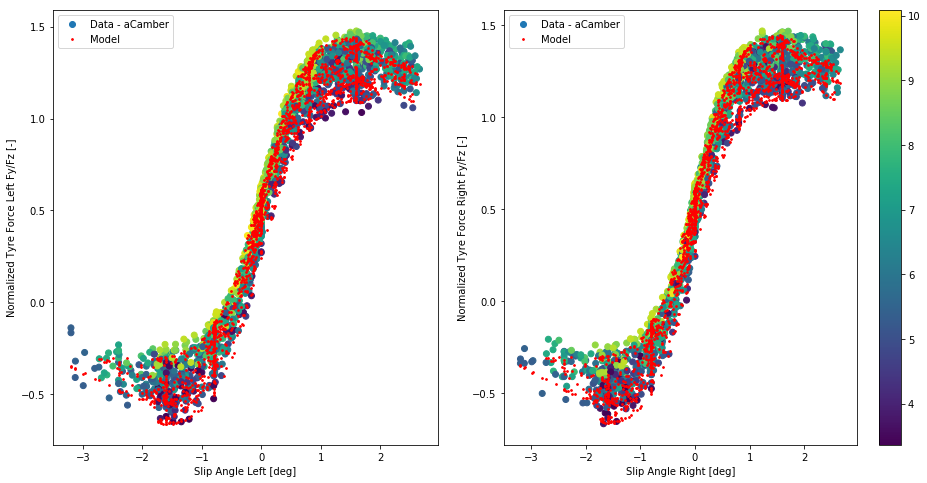

In [92]:
# evaluate the fitted model
FyResultFL = tyrefun(xDescale[:NPars], dataframeLap.aSlipFL, dataframeLap.aCamberFL, dataframeLap.FzTyreFL)
FyResultFR = tyrefun(xDescale[NPars:], dataframeLap.aSlipFR, dataframeLap.aCamberFR, dataframeLap.FzTyreFR)

# plot the model vs the data
fig = plt.figure(figsize=[16, 8])

ax1 = plt.subplot2grid((1, 16), (0, 0), colspan=7)
ax2 = plt.subplot2grid((1, 16), (0, 8), colspan=8)

s1 = ax1.scatter(dataframeLap.aSlipFL, dataframeLap.FyTyreFL / dataframeLap.FzTyreFL, 
                 c=dataframeLap.aCamberFL,
                 vmin=cmin,
                 vmax=cmax,
                 label="Data - aCamber");
ax1.scatter(dataframeLap.aSlipFL, FyResultFL / dataframeLap.FzTyreFL, s = 3, c="r", label="Model");
ax1.set_xlabel("Slip Angle Left [deg]");
ax1.set_ylabel("Normalized Tyre Force Left Fy/Fz [-]");
ax1.legend();

s2 = ax2.scatter(dataframeLap.aSlipFR, dataframeLap.FyTyreFR / dataframeLap.FzTyreFR,
                 c=dataframeLap.aCamberFR,
                 vmin=cmin,
                 vmax=cmax,
                 label="Data - aCamber");
ax2.scatter(dataframeLap.aSlipFR, FyResultFR / dataframeLap.FzTyreFR, s = 3, c="r", label="Model");
ax2.set_xlabel("Slip Angle Right [deg]");
ax2.set_ylabel("Normalized Tyre Force Right Fy/Fz [-]");
ax2.legend();
fig.colorbar(s2);

### Thank you.

### Any questions?